In [1]:
"""
Build the skill set and distances between inventors on patents
"""

'\nBuild the skill set and distances between inventors on patents\n'

In [2]:
import os
import pandas as pd
import pickle
import numpy as np
import networkx as nx
from itertools import combinations
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise

In [3]:
os.chdir("D:\\IDEA Masters\\TFM data")

In [4]:
inventor = pd.read_csv("Inventor Data.csv")

C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
"""
Create a data set which takes all the inventors active between 2012 and 2018 and their full
entire history. For example an inventor maybe active in 2012 but have had their first patent in the 80s.
This is to create a left complete history of all active inventor skills.
"""

'\nCreate a data set which takes all the inventors active between 2012 and 2018 and their full\nentire history. For example an inventor maybe active in 2012 but have had their first patent in the 80s.\nThis is to create a left complete history of all active inventor skills.\n'

In [5]:
print(len(inventor["inventor_id"].unique()))
print(len(inventor["patent_id"].unique()))
len(inventor["assignee_id"].unique())

3108197
6190746


401411

In [7]:
years = np.arange(2002, 2019)

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017])

In [8]:
inventor_index = inventor[inventor["year"].isin(years)]["inventor_id"].unique()
data12_18 = inventor[inventor["inventor_id"].isin(inventor_index)]
del inventor

In [9]:
"""
Take only the patents with more than one inventor as I am only interested in collaborations
"""
"""
before = len(data12_18["inventor_id"].unique())
"""

data12_18 = data12_18[data12_18["no_inventors"] != 1]

"""
after = len(data12_18["inventor_id"].unique())

print("No of inventors, ", len(data12_18["inventor_id"].unique()))
print("No of patents, ", len(data12_18["patent_id"].unique()))
print("No of firms, ", len(data12_18["assignee_id"].unique()))

print("The number of patents with only one inventor is, ",  ((before-after)/after)*100)

# Save this data set
#data12_18.to_csv("Collaborations 2012 to 2018.csv")
"""

'\nafter = len(data12_18["inventor_id"].unique())\n\nprint("No of inventors, ", len(data12_18["inventor_id"].unique()))\nprint("No of patents, ", len(data12_18["patent_id"].unique()))\nprint("No of firms, ", len(data12_18["assignee_id"].unique()))\n\nprint("The number of patents with only one inventor is, ",  ((before-after)/after)*100)\n\n# Save this data set\n#data12_18.to_csv("Collaborations 2012 to 2018.csv")\n'

In [32]:
#data12_18 = pd.read_csv("Collaborations 2012 to 2018.csv")
"""
Load the technology space
"""
os.chdir("D:\\IDEA Masters\\TFM data\\Paper Data")
graph = nx.read_gml("Technology Network from PS.gml")

adj_tech = nx.to_numpy_array(graph, nodelist=graph.nodes)

np.fill_diagonal(adj_tech, 1)

In [11]:
"""
Count the skill level of all inventors active in the period
"""

n = len(data12_18["inventor_id"].unique())
section_counts = np.zeros((n, len(list(graph.nodes()))))
section_counts = pd.DataFrame(section_counts, columns=list(graph.nodes()))
section_counts.set_index(data12_18["inventor_id"].unique(), inplace=True)

In [12]:

for year in years[:-1]:

    # Take the index for all patents awarded in that year

    idx = data12_18.index[data12_18["year"] == year].tolist()

    # List the set of inventors who were active in that period
    inventors_active = data12_18.loc[idx]["inventor_id"].unique()

    # Take the data for all active inventors in 2018 for all years. Each one is
    #active for their own period, some one year, some 10.

    idx2 = data12_18.index[data12_18["inventor_id"].isin(inventors_active)].tolist()
    data_year = data12_18.loc[idx2]
    data_year = data_year[data_year["year"] <= year]

    n = len(data_year["inventor_id"].unique())

    for (inv, inv_patent) in data_year.groupby(["inventor_id"]):

        for sc in inv_patent["section_class_sub"].unique():

            section_counts.at[inv, sc] = section_counts.at[inv, sc] + 1
            
    print(year)

    section_counts.to_csv(f"Section Counts {year}.csv", index_label=False)

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [20]:
@njit(parallel=True)
def MeasureDist(inv1_skills, inv2_skills, adj_tech):

    g = np.outer(np.transpose(inv1_skills), inv2_skills) * adj_tech
    g = np.where(g == 0, np.nan, g)

    return  np.nanmean(g)

In [18]:
%%time
"""
Find the distance between each inventors vector of skills using the new technology space.

!!!
This code takes a long time to run and is probably not very efficient.
!!

The steps are as follows:
    1) Take each patent in the restricted data set
    2) Find all possible combinations of inventors who produced that patent
    3) Find the pairwise distance between their skills using the following steps:

        a. Take the outer product of their skill vectors. This will produce a matrix of zeros and ones.
        Each one will correspond to the interaction between two of their skills.
        b. Multiply this matrix element by element with the adjacency matrix of the technology space.
        This will multiply the proximity of both skills for all skill interactions found in step a.
        c. Take the mean of all these distances.

        e.g.     E[(Skill s of inventor i) x (Skill t of inventor k) x (Proximity of s and t)]
"""

os.chdir("D:\\IDEA Masters\\TFM data\\Paper Data")
patent_inv_distances = dict.fromkeys(data12_18["patent_id"].unique())
years = [2011, 2012]

for year in years:

    section_counts = pd.read_csv(f"Section Counts {year-1}.csv")
    section_counts = section_counts[[c for c in graph.nodes()]]
    # Here if I group by section subclass to count as double - this has no effect
    # the dictionary will map to all the patents in the end either way
    for idx, df in data12_18[data12_18["year"] == year].groupby("patent_id"):

        pat_no = idx

        distances = []

        for (inv1, inv2) in combinations(df["inventor_id"].unique(), 2):

            inv1_skills = np.array(section_counts.loc[inv1])
            inv2_skills = np.array(section_counts.loc[inv2])

            average = MeasureDist(inv1_skills, inv2_skills, adj_tech)

            distances.append(average)

        patent_distance = np.nanmean(distances)

        patent_inv_distances[pat_no] = patent_distance

    print(year)

<timed exec>:47: RuntimeWarning: Mean of empty slice
<timed exec>:47: RuntimeWarning: Mean of empty slice


2011
2012
Wall time: 2h 42min 10s


In [19]:

data12_18["inventor_distance"] = data12_18["patent_id"].map(patent_inv_distances)

In [18]:
"""
Build the knowledge space and collaboration space just for 2018 to show visually
the collaboration among team members.
"""

'\nBuild the knowledge space and collaboration space just for 2018 to show visually\nthe collaboration among team members.\n'

In [20]:
print(len(data12_18["inventor_id"].unique()))
print(len(data12_18["patent_id"].unique()))

666368
3247800


In [21]:
data12_18.to_csv("Collaborations 2003 to 2018.csv")

In [5]:
"""
Remove fixed effects by technological sector
"""

os.chdir("D:\\IDEA Masters\\TFM data\\Paper Data")

'\nRemove fixed effects by technological sector\n'

In [6]:
year_cites_total = inventor.groupby("year")["citations"].mean()

color_dict={"H":"tab:gray", "A":"tab:blue", "B":"tab:orange", "C":"tab:green",
            "D":"tab:red", "E":"tab:purple", "F":"tab:brown", "G":"tab:pink", }

tech_cites = inventor.groupby("section")["citations"].mean()
tech_cites = pd.DataFrame(tech_cites)
tech_cites.reset_index(inplace=True)
tech_cites_sub = inventor.groupby("section_class_sub")["citations"].mean()
tech_cites_sub = pd.DataFrame(tech_cites_sub)
tech_cites_sub.reset_index(inplace=True)

In [1]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, facecolor="w", figsize=(6, 12))
fig.suptitle("Within Year and Technology Class Heterogeneity", fontsize=16)
ax1.plot(year_cites_total, lw=2, color="black", dashes=[3,1,3,1], label="Average")
markers=["o", "1", "v", "s", "d", "X","p","*"]

for (i, sec) in enumerate(inventor["section"].unique()):
    sec_data = inventor[inventor["section"]==sec]
    year_cites = sec_data.groupby("year")["citations"].mean()
    ax1.plot(year_cites, label=f"{sec}", color=color_dict[sec], marker=markers[i], alpha=0.5)
ax1.legend()
ax1.set_title("By Year", fontsize=14)
ax1.set_ylabel("Mean Citations", fontsize=13)


bar = sns.barplot(x="section", y="citations", data=tech_cites, alpha=0.2, ax=ax2)
hatches = ['/','\\', '/','\\', '/', '\\', '/', '\\']

# Loop over the bars
for i, thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

ax2.set_xlabel("")
ax2.set_ylabel("Mean Citations", fontsize=13)
ax2.set_title("By Class", fontsize=14)



sns.histplot(tech_cites_sub["citations"], ax=ax3, color="firebrick", bins=20, hatch="/", alpha=0.2)
ax3.set_title("By Subclass", fontsize=14)
ax3.set_xlabel("Mean Citations", fontsize=13)
ax3.set_ylabel("Count", fontsize=13)

plt.tight_layout()

' \nfig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, facecolor="w", figsize=(6, 12))\nfig.suptitle("Within Year and Technology Class Heterogeneity", fontsize=16)\nax1.plot(year_cites_total, lw=2, color="black", dashes=[3,1,3,1], label="Average")\nmarkers=["o", "1", "v", "s", "d", "X","p","*"]\n\nfor (i, sec) in enumerate(inventor["section"].unique()):\n    sec_data = inventor[inventor["section"]==sec]\n    year_cites = sec_data.groupby("year")["citations"].mean()\n    ax1.plot(year_cites, label=f"{sec}", color=color_dict[sec], marker=markers[i], alpha=0.5)\nax1.legend()\nax1.set_title("By Year", fontsize=14)\nax1.set_ylabel("Mean Citations", fontsize=13)\n\n\nbar = sns.barplot(x="section", y="citations", data=tech_cites, alpha=0.2, ax=ax2)\nhatches = [\'/\',\'\\\', \'/\',\'\\\', \'/\', \'\\\', \'/\', \'\\\']\n\n# Loop over the bars\nfor i, thisbar in enumerate(bar.patches):\n    # Set a different hatch for each bar\n    thisbar.set_hatch(hatches[i])\n\nax2.set_xlabel("")\nax2.set_

In [10]:
fig.savefig("Year tech citations.png", dpi=300)

In [12]:
del sec_data

In [ ]:

tech_cites_sub_dict = dict(zip(tech_cites_sub["section_class_sub"],
                               tech_cites_sub["citations"]))
year_cites_total_dict = dict(year_cites_total)

In [ ]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
year_cites_total = inventor.groupby("year")["year_norm_cites"].mean()
fig, ax = plt.subplots(facecolor="w")
plt.plot(year_cites_total)


In [3]:
os.chdir("D:\\IDEA Masters\\TFM data\\Paper Data")
colabs = pd.read_csv("Collaborations 2003 to 2018.csv")

In [33]:
year_tech_norm = inventor.groupby(["section_class_sub", "year"])["citations"].mean()
year_tech_norm_dict = dict(year_tech_norm)

In [43]:
colabs["year_mean_cites"] = colabs["year"].map(year_cites_total_dict)
colabs["subclass_mean_cites"] = colabs["section_class_sub"].map(tech_cites_sub_dict)
colabs["year_norm_cites"] = colabs["citations"] / colabs["year_mean_cites"]
colabs["tech_norm_cites"] = colabs["citations"] / colabs["subclass_mean_cites"]
colabs["year_tech_mean_cites"] = colabs.set_index(["section_class_sub", "year"]).index.map(year_tech_norm_dict.get)
colabs["year_tech_norm_cites"] = colabs["citations"] / colabs["year_tech_mean_cites"]

In [7]:
total_skill_dict = pickle.load(open("patent_total_skill_dict.p", "rb"))

In [8]:
colabs["total_skill"] = colabs["patent_id"].map(total_skill_dict)


In [10]:
data12_18 = colabs[colabs["year"].isin(np.arange(2003, 2019))]

#data12_18 = data12_18.drop(columns=["assignee_id", "location_id_x","location_id_y", "section", "section_class",
#                                    "section_class_sub"])


no_patents = data12_18.groupby(["inventor_id", "year"])["patent_id"].count() \
         .groupby(level=0).cumsum()

no_patents = no_patents.reset_index()

no_patents = no_patents[no_patents["year"].isin(np.arange(2003, 2019))]

data12_18 = data12_18.dropna(subset=["inventor_distance"])

inventor_panel_1218 = data12_18.groupby(["inventor_id", "year"])["citations", "year_norm_cites",
                                                            "tech_norm_cites", "year_tech_norm_cites"].sum()
inventor_panel_1218 = inventor_panel_1218.reset_index()

mean_inve_d = data12_18.groupby(["inventor_id", "year"])["no_inventors", "inventor_distance","total_skill"].mean()
inventor_panel_1218 = inventor_panel_1218.merge(mean_inve_d, how="inner", on=["inventor_id", "year"])

mean_cites = data12_18.groupby(["inventor_id", "year"])["citations"].mean()
mean_cites = mean_cites.reset_index()

inventor_panel_1218 = inventor_panel_1218.merge(mean_cites, how="inner", on=["inventor_id", "year"])
inventor_panel_1218 = inventor_panel_1218.rename(columns={"citations_y":"mean_citations"})
inventor_panel_1218 = inventor_panel_1218.rename(columns={"citations_x":"citations"})

<ipython-input-10-12eb7aa29ab5>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  inventor_panel_1218 = data12_18.groupby(["inventor_id", "year"])["citations", "year_norm_cites",
<ipython-input-10-12eb7aa29ab5>:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_inve_d = data12_18.groupby(["inventor_id", "year"])["no_inventors", "inventor_distance","total_skill"].mean()


In [11]:
mean_cites_norm = data12_18.groupby(["inventor_id", "year"])["year_tech_norm_cites"].mean()
mean_cites_norm = mean_cites_norm.reset_index()

inventor_panel_1218 = inventor_panel_1218.merge(mean_cites_norm, how="inner", on=["inventor_id", "year"])
inventor_panel_1218 = inventor_panel_1218.rename(columns={"year_tech_norm_cites_y":"mean_year_tech_norm_cites"})
inventor_panel_1218 = inventor_panel_1218.rename(columns={"year_tech_norm_cites_x":"year_tech_norm_cites"})


inventor_panel_1218 = inventor_panel_1218.merge(no_patents, how="inner", on=["inventor_id", "year"])
inventor_panel_1218 = inventor_panel_1218.rename(columns={"patent_id":"no_patents"})

In [12]:
len(inventor_panel_1218["inventor_id"].unique())

1252729

In [38]:
colabs = colabs.drop(columns=["Unnamed: 0"])

In [65]:
colabs.to_csv("Collaborations 2012 to 2018.csv", index=False)

In [40]:
#inventor_panel.to_csv("Inventor Panel 2011 to 2012.csv", index=False)

In [13]:
inventor_panel_1218 = inventor_panel_1218.dropna(subset=["inventor_distance"])
inventor_panel_1218 = inventor_panel_1218.dropna(subset=["citations"])
inventor_panel_1218 = inventor_panel_1218.dropna(subset=["year_tech_norm_cites"])
inventor_panel_1218["ln_year_tech_norm_cites"] = np.log(inventor_panel_1218["year_tech_norm_cites"] + 1)
inventor_panel_1218["ln_citations"] = np.log(inventor_panel_1218["citations"] + 1)
len(inventor_panel_1218["inventor_id"].unique())

1252729

In [16]:
inventor_panel_1218["ln_mean_year_tech_norm_cites"] = np.log(inventor_panel_1218["mean_year_tech_norm_cites"] + 1)

Text(0.5, 1.0, 'Proximity and Citations')

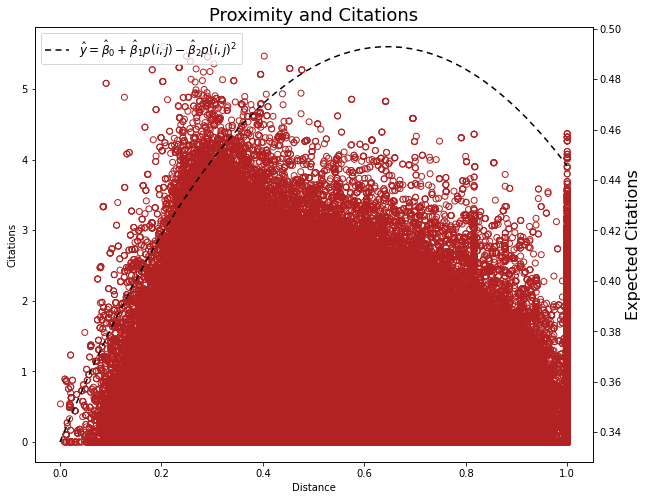

In [18]:
inventor_panel_1218 = inventor_panel_1218.dropna(subset=["ln_mean_year_tech_norm_cites"])
coefficients = np.polyfit(inventor_panel_1218["inventor_distance"],
                          inventor_panel_1218["ln_mean_year_tech_norm_cites"], 2)
poly = np.poly1d(coefficients)
x = np.linspace(0, 1)
quad_fit = poly(x)

fig, ax = plt.subplots(facecolor="w", figsize=(10, 8))
ax.scatter(inventor_panel_1218["inventor_distance"], inventor_panel_1218["ln_mean_year_tech_norm_cites"], edgecolors="firebrick",
                facecolors="none")
ax.set_xlabel("Distance")
ax.set_ylabel("Citations")
ax2 = ax.twinx()
ax2.plot(x, quad_fit, dashes=[4,3,4,3], color="k", label=r"$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 p(i, j) -  \hat{\beta}_2 p(i, j)^2$")
ax2.set_ylabel("Expected Citations", fontsize=16)
ax2.set_xlabel(r"Proximity: $p(i, j)$", fontsize=16)
plt.legend(fontsize="large")
plt.title("Proximity and Citations", fontsize=18)

In [15]:
inventor_panel_1218.to_csv("Inventor Panel 2003 to 2018.csv", index=False)

In [42]:
del inventor
colabs = pd.read_csv("Collaborations 2012 to 2018.csv")

C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [50]:
os.chdir("D:\\IDEA Masters\\TFM data\\Paper Data")
inventor_panel_0210 = pd.read_csv("Inventor Panel 2002 to 2010.csv")

In [52]:
inventor_panel_0210 = inventor_panel_0210[inventor_panel_1218.columns]

In [57]:
inventor_panel_1112 = inventor_panel

In [60]:
panel = pd.concat([inventor_panel_0210, inventor_panel_1112, inventor_panel_1218])

In [61]:
panel = panel.sort_values(["inventor_id", "year"])

In [62]:
years_active = pd.read_csv("Years active.csv")
panel = panel.merge(years_active, how="inner", on=["inventor_id", "year"])


In [64]:
pickle.dump(year_cites_total_dict, open("year_cites_total_dict.p", "wb"))
pickle.dump(year_tech_norm_dict, open("year_tech_norm_dict.p", "wb"))
pickle.dump(tech_cites_sub_dict, open("tech_cites_sub_dict.p", "wb"))

In [66]:
del colabs
del data12_18
del inventor_panel_1218
del inventor_panel_1112
del inventor_panel_0210
del years_active

os.chdir("D:\\IDEA Masters\\TFM data")
inventor = pd.read_csv("Inventor Data.csv")


no_patents = inventor.groupby(["inventor_id", "year"])["patent_id"].count() \
         .groupby(level=0).cumsum()

no_patents = no_patents.reset_index()

C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [67]:
panel = panel.drop(columns=["no_patents", "v1"])
panel = panel.rename(columns={"count":"years_active"})

In [69]:
no_patents_dict = dict(zip(zip(no_patents["inventor_id"], no_patents["year"]), no_patents["patent_id"]))

panel["no_patents"] =  panel.set_index(["inventor_id", "year"]).index.map(no_patents_dict.get)

In [70]:
panel.to_csv("InventorPanel_2002_2018.csv", index=False)

In [71]:
pickle.dump(no_patents_dict, open("no_patents_dict.p", "wb"))

In [4]:
"""
At the collaboration level!
"""
colabs = pd.read_csv("Collaborations 2001 to 2010.csv")
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
colabs = colabs[colabs["year"].isin([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]

C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
graph = nx.read_gml("Technology Network from PS.gml")
adj_tech = nx.to_numpy_array(graph, nodelist=graph.nodes)
np.fill_diagonal(adj_tech, 1)

In [21]:
%%time

patent_inv_var = dict.fromkeys(colabs["patent_id"].unique())
patent_inv_across_p = dict.fromkeys(colabs["patent_id"].unique())

for year in years:

    patent_inv_skill_vector = dict.fromkeys(colabs[colabs["year"] == year]["patent_id"].unique())

    team_skills_bar_yearly =  np.zeros((1, 634))
    section_counts = pd.read_csv(f"Section Counts {year}.csv")
    section_counts = section_counts.loc[colabs[colabs["year"] == year]["inventor_id"].unique()]
    section_counts = section_counts[[c for c in graph.nodes()]]

    for patent, df in colabs[colabs["year"] == year].groupby("patent_id"):

        team_skills = np.zeros((1, 634))

        for inv in df["inventor_id"].unique():

            team_skills = team_skills + np.array(section_counts.loc[inv])

        patent_inv_skill_vector[patent] = team_skills
        team_var = np.var(team_skills)

        patent_inv_var[patent] = team_var

        team_skills_bar_yearly = team_skills_bar_yearly + team_skills

    year_average_skills = team_skills_bar_yearly / len(colabs[colabs["year"] == year]["patent_id"].unique())


    for patent in colabs[colabs["year"] == year]["patent_id"].unique():

        team_vector = patent_inv_skill_vector[patent]
        dist_from_mean = MeasureDist(year_average_skills, team_vector, adj_tech)

        patent_inv_across_p[patent] = dist_from_mean

    print(year)

2002
2003
2004
2005
2006
2007
2008
2009
2010
Wall time: 2h 21s


In [22]:
colabs["inventor_variance"] = colabs["patent_id"].map(patent_inv_var)
colabs["across_team_distance"] = colabs["patent_id"].map(patent_inv_across_p)


In [23]:
colabs.to_csv("Collaborations 2001 to 2010 all three.csv")

In [4]:
colabs = pd.read_csv("Collaborations 2001 to 2010 all three.csv")

In [5]:
colabs = colabs.drop(columns=["inventor_id", "location_id_x", "assignee_id", "location_id_y"])

In [7]:
colabs = colabs.drop(columns=["Unnamed: 0"])
colabs = colabs.drop_duplicates()

In [ ]:
colabs = colabs.rename(columns={"Unnamed: 0":"obs_id"})

In [8]:
colabs.to_csv("Patent Level Data.csv", index=False)

In [3]:

""" Cosine similarity distance! """


os.chdir("D:\\IDEA Masters\\TFM data\\Paper Data")

In [5]:
data = pd.read_csv("Collaborations 2003 to 2018.csv")

In [6]:
data = data[["year", "patent_id", "inventor_id"]]

In [15]:
del section_counts

In [7]:
import warnings
warnings.filterwarnings("ignore")

patent_inv_distances = dict.fromkeys(data["patent_id"].unique())
years = np.arange(2003, 2019)
for year in years:

    section_counts = pd.read_csv(f"Section Counts {year-1}.csv")
    # Here if I group by section subclass to count as double - this has no effect
    # the dictionary will map to all the patents in the end either way
    for idx, df in data[data["year"] == year].groupby("patent_id"):

        pat_no = idx

        distances = []

        for (inv1, inv2) in combinations(df["inventor_id"].unique(), 2):

            inv1_skills = np.array([section_counts.loc[inv1]])
            inv2_skills = np.array([section_counts.loc[inv2]])

            if (np.sum(inv1_skills) > 0) and (np.sum(inv2_skills) > 0):

                inv1_skills[inv1_skills > 0 ] = 1
                inv2_skills[inv2_skills > 0 ] = 1

                average = pairwise.cosine_similarity(inv1_skills, inv2_skills)

                distances.append(average)
            else:
                distances.append(np.nan)

        patent_distance = np.nanmean(distances)

        patent_inv_distances[pat_no] = patent_distance

    print(year)
    del section_counts

pickle.dump(patent_inv_distances, open("patent_inv_distances cosine.p", "wb"))

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [4]:

patent_data = pd.read_csv("Unique patent_data_set 2003 to 2018.csv")

In [6]:
patent_data["cosine_similarity"] = patent_data["patent_id"].map(patent_inv_distances)
patent_data["cosine_similarity"] = patent_data["cosine_similarity"].astype(float)

In [8]:
patent_data["cosine_similarity"].describe()

count    1.706031e+06
mean     5.033171e-01
std      2.518696e-01
min      0.000000e+00
25%      3.270056e-01
50%      5.000000e-01
75%      6.839768e-01
max      1.000000e+00
Name: cosine_similarity, dtype: float64

In [19]:
patent_data["inventor_distance"].describe()

count    1.706031e+06
mean     4.128321e-01
std      1.738677e-01
min      1.000000e-03
25%      2.884702e-01
50%      3.678577e-01
75%      4.852600e-01
max      1.000000e+00
Name: inventor_distance, dtype: float64

Text(0, 0.5, 'Probability')

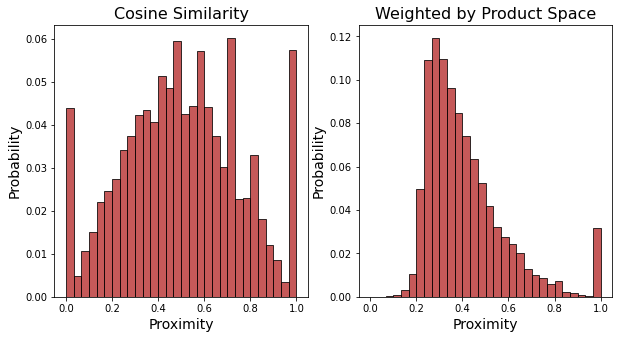

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, facecolor="w", figsize=(10, 5))
ax1.set_title("Cosine Similarity", fontsize=16)
ax1.set_xlabel("Proximity", fontsize=14)
ax1.set_ylabel("Probability", fontsize=14)
sns.histplot(patent_data["cosine_similarity"], stat="probability", color="firebrick", bins=30, ax=ax1)
ax2.set_title("Weighted by Product Space", fontsize=16)
sns.histplot(patent_data["inventor_distance"], stat="probability",  color="firebrick", bins=30, ax=ax2)
ax2.set_xlabel("Proximity", fontsize=14)
ax2.set_ylabel("Probability", fontsize=14)

In [18]:
fig.savefig("Cosine VS Prod.png", dpi=300)

In [ ]:
patent_data.dropna(subset=["cosine_similarity", "inventor_distance"], inplace=True)


np.corrcoef(patent_data["cosine_similarity"], patent_data["inventor_distance"])

Text(0.5, 1.0, 'Proximity and Citations')

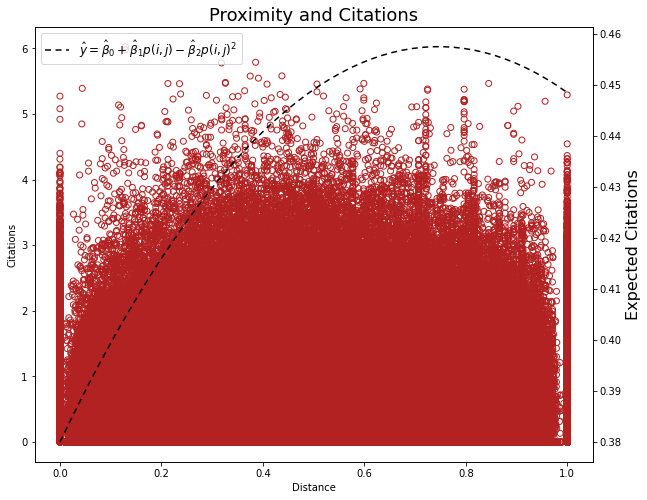

In [12]:
patent_data["ln_year_tech_norm_cites"] = np.log(patent_data["year_tech_norm_cites"] + 1)

patent_data = patent_data.dropna(subset=["ln_year_tech_norm_cites"])
coefficients = np.polyfit(patent_data["cosine_similarity"],
                          patent_data["ln_year_tech_norm_cites"], 2)
poly = np.poly1d(coefficients)
x = np.linspace(0, 1)
quad_fit = poly(x)

fig, ax = plt.subplots(facecolor="w", figsize=(10, 8))
ax.scatter(patent_data["cosine_similarity"], patent_data["ln_year_tech_norm_cites"], edgecolors="firebrick",
                facecolors="none")
ax.set_xlabel("Distance")
ax.set_ylabel("Citations")
ax2 = ax.twinx()
ax2.plot(x, quad_fit, dashes=[4,3,4,3], color="k", label=r"$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 p(i, j)"
                                                         r" -  \hat{\beta}_2 p(i, j)^2$")
ax2.set_ylabel("Expected Citations", fontsize=16)
ax2.set_xlabel(r"Proximity: $p(i, j)$", fontsize=16)
plt.legend(fontsize="large")
plt.title("Proximity and Citations", fontsize=18)

Text(0.5, 1.0, 'Proximity and Citations')

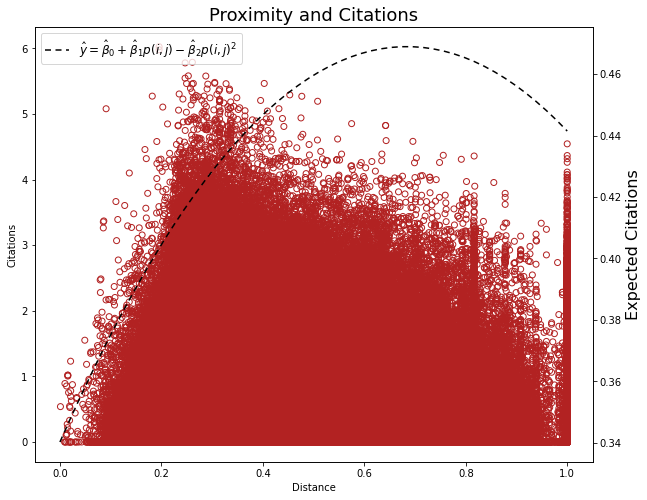

In [31]:

coefficients = np.polyfit(patent_data["inventor_distance"],
                          patent_data["ln_year_tech_norm_cites"], 2)
poly = np.poly1d(coefficients)
x = np.linspace(0, 1)
quad_fit = poly(x)

fig, ax = plt.subplots(facecolor="w", figsize=(10, 8))
ax.scatter(patent_data["inventor_distance"], patent_data["ln_year_tech_norm_cites"], edgecolors="firebrick",
                facecolors="none")
ax.set_xlabel("Distance")
ax.set_ylabel("Citations")
ax2 = ax.twinx()
ax2.plot(x, quad_fit, dashes=[4,3,4,3], color="k", label=r"$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 p(i, j)"
                                                         r" -  \hat{\beta}_2 p(i, j)^2$")
ax2.set_ylabel("Expected Citations", fontsize=16)
ax2.set_xlabel(r"Proximity: $p(i, j)$", fontsize=16)
plt.legend(fontsize="large")
plt.title("Proximity and Citations", fontsize=18)

In [34]:
patent_data.to_csv("Unique patent_data_set 2003 to 2018.csv", index=False)

In [4]:

"""
Check correlation between distance and number of target industries
"""

'\nCheck correlation between distance and number of target industries\n'

In [7]:
data.drop(columns=["inventor_id"], inplace=True)
data.drop_duplicates(inplace=True)

In [8]:
data = data[["patent_id", "section", "section_class", "section_class_sub", "inventor_distance", "year", "year_tech_norm_cites"]]

In [10]:
skill_counts = data.groupby("patent_id").count()

skill_counts.reset_index(inplace=True)

no_target_skills = dict(zip(skill_counts["patent_id"],
                            skill_counts["section_class_sub"]))

In [21]:
patent_data = pd.read_csv("Unique patent_data_set 2003 to 2018.csv")

In [22]:
patent_data["no_target_skills"] = patent_data["patent_id"].map(no_target_skills)

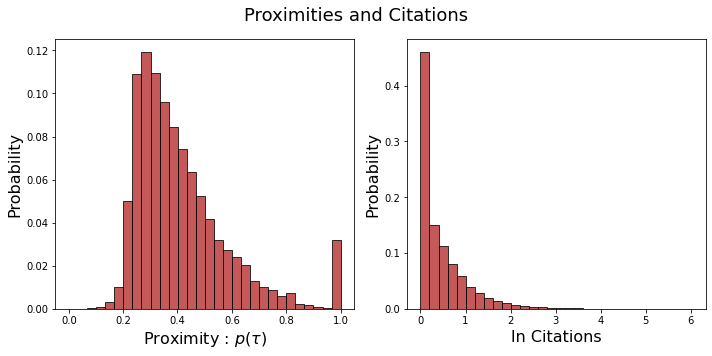

In [35]:
patent_data["ln_citations"] = np.log(patent_data["citations"] + 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, facecolor="w", figsize=(10, 5))
fig.suptitle("Proximities and Citations", fontsize=18)

ax1.set_xlabel(r"Proximity : $p(\tau)$", fontsize=16)
ax1.set_ylabel("Probability", fontsize=16)
sns.histplot(patent_data["inventor_distance"], stat="probability", bins=30, ax=ax1, color="firebrick")

ax2.set_xlabel("ln Citations", fontsize=16)
ax2.set_ylabel("Probability", fontsize=16)
sns.histplot(patent_data["ln_year_tech_norm_cites"], stat="probability", bins=30, ax=ax2, color="firebrick")
plt.tight_layout()

In [36]:
fig.savefig("Proximities and Citations.png", dpi=300)